## **1. Preparing the Environment**

In [1]:
import pandas as pd

import numpy as np
import pickle
from tqdm import tqdm
import category_encoders as ce
import statsmodels.api as sm
import sklearn.ensemble
import lightgbm
import sklearn.metrics
import time
import seaborn as sns
import matplotlib.pyplot as plt


tqdm.pandas()

/Applications/Conda/anaconda3/envs/mlim/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel







## **2. Data Preparation and Feature Creation**

### **2.1 Converging Train and Test Data Structure**

In [ ]:
# loading the data
baskets = pd.read_parquet('baskets.parquet')
coupons = pd.read_parquet('coupons.parquet')

# merging the data
df = baskets.copy()
# detecting similar columns and merging on similar columns
similar = [x for x in coupons.columns if x in baskets.columns] # i.e. ['shopper', 'product', 'week'] 
df = df.merge(coupons, how='left', left_on=similar, right_on=similar)
df.to_parquet('df.parquet')

In [2]:
def get_tr(df, week):
    import itertools
    week = [week] if type(week) != list else week

    product = list(range(250))
    shopper = list(range(2000))
    tr = pd.DataFrame(itertools.product(shopper, week, product))
    tr.rename(columns={0:'shopper', 1:'week', 2:'product'}, inplace=True)
    tr = tr.merge(df, how='left', left_on=list(tr.columns), right_on=list(tr.columns))
    tr['purchased'] = tr['price'].notna().astype(int) # target
    tr['coupon'] = tr['discount'].notna().astype(int)

    return tr

In [ ]:
df_full = pd.read_parquet('df.parquet')

# reduce to relevant shoppers and create new structure for the full data
df = df_full.loc[df_full['shopper'] < 2000]
tr = get_tr(df, list(range(90)))
tr.to_parquet('tr.parquet')

In [3]:
tr_full = pd.read_parquet('tr.parquet')
tr_full

,shopper,week,product,price,discount,purchased,coupon
0,0,0,0,NaN,NaN,0,0
1,0,0,1,NaN,NaN,0,0
2,0,0,2,NaN,NaN,0,0
3,0,0,3,NaN,NaN,0,0
4,0,0,4,NaN,NaN,0,0
...,...,...,...,...,...,...,...
44999995,1999,89,245,549.0,NaN,1,0
44999996,1999,89,246,NaN,NaN,0,0
44999997,1999,89,247,NaN,NaN,0,0
44999998,1999,89,248,NaN,NaN,0,0







### **2.2 Cleaning Prices: Product Price Map**

In [4]:
tr_full = pd.read_parquet('tr.parquet')

# cleaning the price feature = removing discounts
tr_full['price_w_discount'] = tr_full['price'].copy()
tr_full.loc[:, 'price'] = (tr_full['price_w_discount'] / (1-tr_full['discount'].fillna(0)/100))
tr_full.loc[:, ['price', 'price_w_discount']].describe().round(2)

,price,price_w_discount
count,1378720.00,1378720.00
mean,590.73,584.34
std,92.70,97.43
min,389.23,234.00
25%,510.00,506.00
50%,582.00,579.00
75%,657.00,654.00
max,837.65,837.00


In [5]:
# comparing mean and mode replacement
tr_full.loc[:, ['product', 'price', 'price_w_discount']].groupby(by='product').agg(['mean', lambda x:x.value_counts().index[0]])

price            price_w_discount           
               mean <lambda_0>             mean <lambda_0>
product                                                   
0        687.967651      688.0       678.646362      688.0
1        560.000000      560.0       554.625061      560.0
2        773.017700      773.0       763.236694      773.0
3        721.981140      722.0       711.966553      722.0
4        620.000000      620.0       612.488525      620.0
...             ...        ...              ...        ...
245      548.968628      549.0       542.371399      549.0
246      701.999084      702.0       694.611084      702.0
247      670.004395      670.0       661.146790      670.0
248      489.988068      490.0       484.861359      490.0
249      498.984344      499.0       493.634705      499.0

[250 rows x 4 columns]

In [ ]:
# extract mode prices from the data which is available at each point in time
mode_prices = {}
for week in tqdm(range(91)):
    mode_prices.update({week: tr_full.loc[tr_full['week'] < week, ['product', 'price']].groupby(by='product').agg(lambda x:x.value_counts().index[0]).to_dict()['price']})
mode_prices

In [9]:
pickle.dump(mode_prices, open('prices.pkl', 'wb'))

In [6]:
mode_prices = pickle.load(open('prices.pkl', 'rb'))
pd.DataFrame(mode_prices)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,NaN,688.0,688.0,688.0,688.0,688.0,688.0,688.0,688.0,688.0,...,688.0,688.0,688.0,688.0,688.0,688.0,688.0,688.0,688.0,688.0
1,NaN,560.0,560.0,560.0,560.0,560.0,560.0,560.0,560.0,560.0,...,560.0,560.0,560.0,560.0,560.0,560.0,560.0,560.0,560.0,560.0
2,NaN,773.0,773.0,773.0,773.0,773.0,773.0,773.0,773.0,773.0,...,773.0,773.0,773.0,773.0,773.0,773.0,773.0,773.0,773.0,773.0
3,NaN,722.0,722.0,722.0,722.0,722.0,722.0,722.0,722.0,722.0,...,722.0,722.0,722.0,722.0,722.0,722.0,722.0,722.0,722.0,722.0
4,NaN,620.0,620.0,620.0,620.0,620.0,620.0,620.0,620.0,620.0,...,620.0,620.0,620.0,620.0,620.0,620.0,620.0,620.0,620.0,620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,NaN,549.0,549.0,549.0,549.0,549.0,549.0,549.0,549.0,549.0,...,549.0,549.0,549.0,549.0,549.0,549.0,549.0,549.0,549.0,549.0
246,NaN,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,...,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0
247,NaN,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,...,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0
248,NaN,490.0,490.0,490.0,490.0,490.0,490.0,490.0,490.0,490.0,...,490.0,490.0,490.0,490.0,490.0,490.0,490.0,490.0,490.0,490.0


### **2.3 Creating Features: Product History Map**

In [7]:
df_full = pd.read_parquet('df.parquet')
df = df_full.loc[df_full['shopper'] < 2000]

In [8]:
n_shoppers = 2000
n_products = 250

product_history = pd.DataFrame(np.array([[-np.infty]]*n_shoppers*n_products).reshape(n_shoppers, n_products))
for col in product_history.columns:
    product_history[col] = product_history[col].apply(lambda x: [x])
product_history.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],...,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf]
1,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],...,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf]
2,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],...,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf]
3,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],...,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf]
4,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],...,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf]


In [9]:
append_hist = lambda row: product_history.loc[row['shopper'], row['product']].append(row['week'])
df.progress_apply(append_hist, axis=1) # using apply is faster than using a for loop
product_history.head()

100%|██████████| 1378720/1378720 [01:24<00:00, 16258.48it/s]


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,[-inf],[-inf],[-inf],[-inf],"[-inf, 24.0, 40.0, 45.0, 51.0, 54.0, 58.0, 60....",[-inf],[-inf],[-inf],[-inf],[-inf],...,"[-inf, 27.0]",[-inf],[-inf],"[-inf, 44.0]","[-inf, 5.0, 8.0, 20.0, 37.0, 38.0, 56.0, 59.0]",[-inf],[-inf],[-inf],[-inf],"[-inf, 10.0, 26.0, 28.0, 32.0, 35.0, 40.0, 65...."
1,"[-inf, 7.0, 11.0, 48.0, 61.0, 66.0, 81.0]","[-inf, 2.0, 6.0, 18.0, 20.0, 27.0, 29.0, 49.0,...",[-inf],[-inf],"[-inf, 5.0, 13.0, 21.0, 23.0, 30.0, 47.0, 69.0...",[-inf],[-inf],[-inf],[-inf],[-inf],...,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],"[-inf, 4.0, 19.0, 22.0, 35.0, 79.0, 88.0]"
2,[-inf],"[-inf, 2.0, 3.0, 6.0, 7.0, 8.0, 9.0, 11.0, 13....",[-inf],[-inf],[-inf],[-inf],"[-inf, 5.0, 10.0, 15.0, 32.0, 54.0]",[-inf],[-inf],"[-inf, 1.0, 17.0]",...,"[-inf, 4.0, 5.0, 16.0, 18.0, 21.0, 26.0, 33.0,...",[-inf],[-inf],[-inf],[-inf],"[-inf, 75.0]",[-inf],[-inf],"[-inf, 3.0, 14.0, 20.0, 42.0, 45.0, 50.0, 51.0...","[-inf, 0.0, 23.0, 30.0, 31.0, 39.0]"
3,[-inf],[-inf],[-inf],[-inf],"[-inf, 7.0, 19.0, 27.0]",[-inf],"[-inf, 0.0, 13.0, 16.0, 18.0, 20.0, 23.0, 30.0...","[-inf, 11.0, 29.0, 38.0, 47.0, 69.0, 85.0]",[-inf],[-inf],...,[-inf],[-inf],[-inf],"[-inf, 57.0]",[-inf],"[-inf, 14.0, 87.0]",[-inf],[-inf],"[-inf, 2.0, 5.0, 10.0, 23.0, 38.0, 44.0, 47.0,...","[-inf, 16.0, 51.0, 71.0]"
4,[-inf],[-inf],"[-inf, 6.0, 15.0, 21.0, 22.0, 27.0, 28.0, 58.0...",[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],...,[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf],[-inf]


In [10]:
pickle.dump(product_history, open('history.pkl', 'wb'))

In [11]:
def get_history(product_history, shopper, product, week):
    arr = np.array(product_history.loc[shopper, product])
    return arr[arr < week]

def get_last_purchase(product_history, shopper, product, week):
    return get_history(product_history, shopper, product, week)[-1]

def get_trend(row, trend_window): # i.e. purchase frequency over the specified trend window
    arr = row['product_history']
    return np.unique(arr[arr >= row['week'] - trend_window]).shape[0] / trend_window






### **2.4 Train Test Split**

In [12]:
def train_test_split(tr_full, test_week, train_window, features='default'):
    time_start = time.time()

    # reducing data to specified weeks
    start = test_week - train_window
    df = tr_full.loc[(tr_full['week'] >= start) & (tr_full['week'] <= test_week), :]

    # cleaning prices using the mode prices map
    df.loc[df['price'].isna(), 'price'] = df.loc[df['price'].isna(), :].progress_apply(lambda row: mode_prices[row['week']][row['product']], axis=1)

    # shopper-product histories
    df.loc[:, 'product_history'] = df.progress_apply(lambda row: get_history(product_history, row['shopper'], row['product'], row['week']), axis = 1)
    df.loc[:, 'last_purchase'] = df['product_history'].progress_apply(lambda x: x[-1])
    df.loc[:, 'weeks_since_last_purchase'] = df['week'] - df['last_purchase']
    df.loc[df['weeks_since_last_purchase'] == np.inf, 'weeks_since_last_purchase'] = np.ceil(df['week'].max() * 1.15)

    # trends
    windows = [1, 3, 5]
    for window in windows:
        df.loc[:, 'trend_'+str(window)] = df.progress_apply(lambda row: get_trend(row, window), axis=1)

    # shopper-product freq --> will be used as management heuristic later
    df.loc[:, 'product_freq'] = df.progress_apply(lambda row: get_trend(row, row['week']), axis=1)

    # drop redundant columns
    redundant = ['discount', 'coupon', 'price_w_discount']
    cols = [col for col in df.columns if col not in redundant]
    tr = df.loc[df['week'] != test_week, cols]
    ts = df.loc[df['week'] == test_week, cols]

    # WOE category encoding
    encoder = ce.WOEEncoder()
    tr.loc[:, 'shopper_WOE'] = encoder.fit_transform(tr['shopper'].astype('category'), tr['purchased'])['shopper'].values
    ts.loc[:, 'shopper_WOE'] = encoder.transform(ts['shopper'].astype('category'))['shopper'].values
    encoder = ce.WOEEncoder()
    tr.loc[:, 'product_WOE'] = encoder.fit_transform(tr['product'].astype('category'), tr['purchased'])['product'].values
    ts.loc[:, 'product_WOE'] = encoder.transform(ts['product'].astype('category'))['product'].values

    # final split
    features = [col for col in tr.columns if col not in ['purchased', 'shopper', 'week', 'product', 'product_history', 'last_purchase']] if features == 'default' else features
    X_train = tr.loc[:, features]
    y_train = tr['purchased']
    X_test = ts.loc[:, features]
    y_test = ts['purchased']

    print(f'[elapsed time] {np.round(time.time() - time_start, 2)/60} min')
    return X_train, y_train, X_test, y_test

In [13]:
tr_full = pd.read_parquet('tr.parquet')
product_history = pickle.load(open('history.pkl', 'rb'))
mode_prices = pickle.load(open('prices.pkl', 'rb'))

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(tr_full, 85, 4)

In [14]:
X_train, y_train, X_test, y_test = pickle.load(open('split_85-4.pkl', 'rb'))

In [15]:
X_train.head()

,price,weeks_since_last_purchase,trend_1,trend_3,trend_5,product_freq,shopper_WOE,product_WOE
20250,688.0,98.0,0.0,0.0,0.0,0.000000,0.079451,-0.708854
20251,560.0,98.0,0.0,0.0,0.0,0.000000,0.079451,0.641240
20252,773.0,98.0,0.0,0.0,0.0,0.000000,0.079451,-0.652174
20253,722.0,98.0,0.0,0.0,0.0,0.000000,0.079451,-1.532484
20254,620.0,11.0,0.0,0.0,0.0,0.098765,0.079451,-0.169311


<AxesSubplot:>

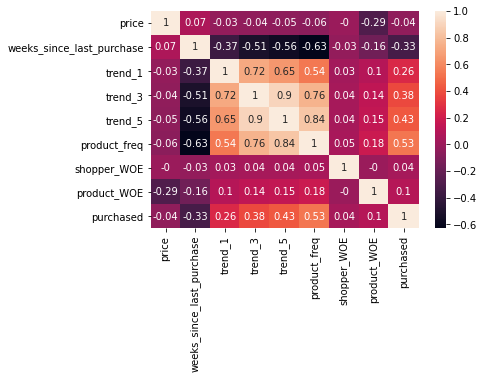

In [16]:
sns.heatmap(X_train.join(y_train).corr().round(2), annot=True)





## **3. Model Training and Evaluation**

In [17]:
class baseline:

    def uniform(X):
        import numpy as np
        return [np.random.uniform(0,1) for x in range(X.shape[0])]

    def constant(X, constant):
        return [constant]*X.shape[0]

In [ ]:
# training models
tr_full = pd.read_parquet('tr.parquet')
product_history = pickle.load(open('history.pkl', 'rb'))
mode_prices = pickle.load(open('prices.pkl', 'rb'))

# different points in time for model validation
weeks = [20, 40, 60, 89]
window = 4
y_hat_tr, y_hat_ts, y_ts, y_tr = {}, {}, {}, {}

parameters_rf = {
    "n_estimators": 100,
    "min_samples_split": 16,
    "max_leaf_nodes": 48,
    "max_features": 0.8,
    "max_depth": 5,
    "bootstrap": True,
    "random_state": 501,
}

time_start = time.time()
for week in weeks:
    # train test split
    X_train, y_train, X_test, y_test = train_test_split(tr_full, week, window)
    dump = (X_train, y_train, X_test, y_test)
    pickle.dump(dump, open(f'split_{week}-{window}.pkl', 'wb'))
    print(f'[week {week}] Finished train-test-split.')

    # logit
    logit = sm.Logit(y_train, X_train).fit()
    logit_c = sm.Logit(y_train, sm.add_constant(X_train)).fit()
    y_hat_tr[f'{week}_logit'] = logit.predict(X_train)
    y_hat_ts[f'{week}_logit'] = logit.predict(X_test)
    y_hat_tr[f'{week}_logit_c'] = logit_c.predict(sm.add_constant(X_train))
    y_hat_ts[f'{week}_logit_c'] = logit_c.predict(sm.add_constant(X_test))
    print(f'[week {week}] Finished logit models.')

    #rf
    random_forest = sklearn.ensemble.RandomForestClassifier(**parameters_rf)
    random_forest.fit(X_train, y_train)
    y_hat_tr[f'{week}_rf'] = random_forest.predict_proba(X_train)[:, 1]
    y_hat_ts[f'{week}_rf'] = random_forest.predict_proba(X_test)[:, 1]
    print(f'[week {week}] Finished random forest model.')

    #lgbm
    lgbm = lightgbm.LGBMClassifier()
    lgbm.fit(X_train, y_train)
    y_hat_tr[f'{week}_lgbm'] = lgbm.predict_proba(X_train)[:, 1]
    y_hat_ts[f'{week}_lgbm'] = lgbm.predict_proba(X_test)[:, 1]
    print(f'[week {week}] Finished boosted trees model.')

    # store true values
    y_ts[week] = y_test
    y_tr[week] = y_train

    # baselines
    y_hat_tr[f'{week}_base-random'] = baseline.uniform(X_train)
    y_hat_tr[f'{week}_base-constant_0'] = baseline.constant(X_train, 0)
    y_hat_tr[f'{week}_base-constant_1'] = baseline.constant(X_train, 1)

    y_hat_ts[f'{week}_base-random'] = baseline.uniform(X_test)
    y_hat_ts[f'{week}_base-constant_0'] = baseline.constant(X_test, 0)
    y_hat_ts[f'{week}_base-constant_1'] = baseline.constant(X_test, 1)

    y_hat_tr[f'{week}_base-mgmt1_freq'] = X_train['product_freq']
    y_hat_ts[f'{week}_base-mgmt1_freq'] = X_test['product_freq']

    dump = (y_hat_tr, y_hat_ts, y_ts, y_tr)
    pickle.dump(dump, open('validation.pkl', 'wb'))
    print(f'[week {week}] Finished week {week}.')

print(f'[elapsed time] {np.round(time.time() - time_start, 2)/60} min')

In [18]:
y_hat_tr, y_hat_ts, y_ts, y_tr = pickle.load(open('validation.pkl', 'rb'))

In [19]:
def calculate_scores(weeks, metric, y, y_hat, verbose=1):
    scores = {}
    metric_name = str(metric)
    metric_name = metric_name[metric_name[:metric_name.rfind(' at ')].rfind(' ')+1:metric_name.rfind(' at ')]
    print('-'*45) if verbose > 0 else None
    for week in weeks:
        keys = [key for key in y_hat.keys() if key.startswith(str(week))]
        print(f'[week {week}] {metric_name}\n'+'-'*45) if verbose > 0 else None
        for key in keys:
            scores[key] = metric(y[week], y_hat[key])
            print(f'[{key}] {metric_name}: {scores[key].round(4)}') if verbose > 0 else None
        print('-'*45) if verbose > 0 else None
    return scores

In [20]:
weeks = [20, 40, 60, 89]
metric = sklearn.metrics.log_loss

scores_tr = calculate_scores(weeks, metric, y_tr, y_hat_tr)

---------------------------------------------
[week 20] log_loss
---------------------------------------------
[20_logit] log_loss: 0.0864
[20_logit_c] log_loss: 0.086
[20_rf] log_loss: 0.0841
[20_lgbm] log_loss: 0.0825
[20_base-random] log_loss: 1.0005
[20_base-constant_0] log_loss: 1.0645
[20_base-constant_1] log_loss: 33.4751
[20_base-mgmt1_freq] log_loss: 0.1871
---------------------------------------------
[week 40] log_loss
---------------------------------------------
[40_logit] log_loss: 0.082
[40_logit_c] log_loss: 0.0812
[40_rf] log_loss: 0.0791
[40_lgbm] log_loss: 0.0778
[40_base-random] log_loss: 1.0
[40_base-constant_0] log_loss: 1.0576
[40_base-constant_1] log_loss: 33.4819
[40_base-mgmt1_freq] log_loss: 0.1318
---------------------------------------------
[week 60] log_loss
---------------------------------------------
[60_logit] log_loss: 0.0804
[60_logit_c] log_loss: 0.0795
[60_rf] log_loss: 0.0774
[60_lgbm] log_loss: 0.076
[60_base-random] log_loss: 0.9995
[60_base-co

In [21]:
weeks = [20, 40, 60, 89]
metric = sklearn.metrics.log_loss

scores_ts = calculate_scores(weeks, metric, y_ts, y_hat_ts)

---------------------------------------------
[week 20] log_loss
---------------------------------------------
[20_logit] log_loss: 0.0851
[20_logit_c] log_loss: 0.0847
[20_rf] log_loss: 0.0824
[20_lgbm] log_loss: 0.0817
[20_base-random] log_loss: 1.0005
[20_base-constant_0] log_loss: 1.055
[20_base-constant_1] log_loss: 33.4845
[20_base-mgmt1_freq] log_loss: 0.1714
---------------------------------------------
[week 40] log_loss
---------------------------------------------
[40_logit] log_loss: 0.0825
[40_logit_c] log_loss: 0.0816
[40_rf] log_loss: 0.0793
[40_lgbm] log_loss: 0.0788
[40_base-random] log_loss: 0.9999
[40_base-constant_0] log_loss: 1.0612
[40_base-constant_1] log_loss: 33.4783
[40_base-mgmt1_freq] log_loss: 0.1271
---------------------------------------------
[week 60] log_loss
---------------------------------------------
[60_logit] log_loss: 0.0802
[60_logit_c] log_loss: 0.0793
[60_rf] log_loss: 0.0768
[60_lgbm] log_loss: 0.0763
[60_base-random] log_loss: 1.0009
[60_ba

In [22]:
def scores_to_df(scores):
    df = pd.DataFrame()
    for score in scores:
        df.loc[score[:2], score[3:]] = scores[score]
    return df

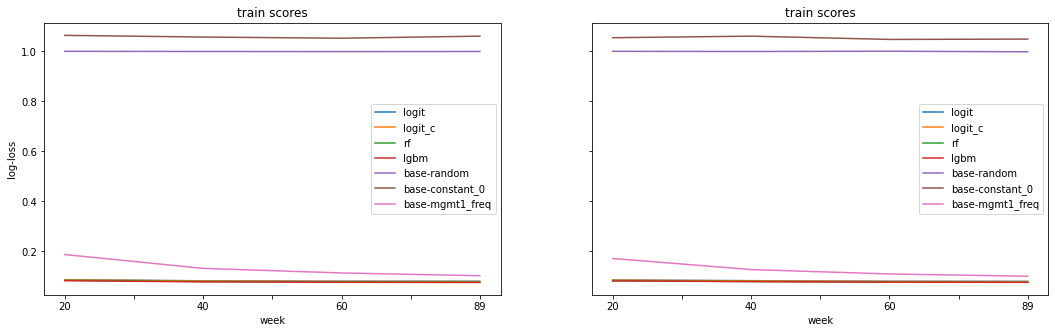

In [23]:
scores_df_tr = scores_to_df(scores_tr)
scores_df_ts = scores_to_df(scores_ts)

fig, axs = plt.subplots(1,2, sharey=True, figsize=(18,5))
scores_df_tr.loc[:, scores_df_tr.columns != 'base-constant_1'].plot(ax=axs[0]);
scores_df_ts.loc[:, scores_df_ts.columns != 'base-constant_1'].plot(ax=axs[1]);
axs[0].set(title='train scores', xlabel='week', ylabel='log-loss')
axs[1].set(title='train scores', xlabel='week');





## **4. Predicting Week 90**

In [24]:
def get_ts(week):
    import itertools
    week = [week] if type(week) != list else week

    product = list(range(250))
    shopper = list(range(2000))
    ts = pd.DataFrame(itertools.product(shopper, week, product))
    ts.rename(columns={0:'shopper', 1:'week', 2:'product'}, inplace=True)
    ts['price'] = ts['discount'] = ts['purchased'] = ts['coupon'] = None

    return ts

In [ ]:
# train-test-split
week = 90
window = 4
tr_full = pd.read_parquet('tr.parquet').append(get_ts(90), ignore_index=True)
product_history = pickle.load(open('history.pkl', 'rb'))
mode_prices = pickle.load(open('prices.pkl', 'rb'))

X_train, y_train, X_test, y_test = train_test_split(tr_full, week, window)
dump = (X_train, y_train, X_test, y_test)
pickle.dump(dump, open(f'split_{week}-{window}.pkl', 'wb'))

In [25]:
X_train, y_train, X_test, y_test = pickle.load(open('split_90-4.pkl', 'rb'))

In [26]:
# training the model
lgbm = lightgbm.LGBMClassifier()
lgbm.fit(X_train, y_train.astype('int32'))
y_hat_tr = lgbm.predict_proba(X_train)[:, 1]
y_hat_ts = lgbm.predict_proba(X_test)[:, 1]

In [27]:
pd.DataFrame(y_hat_tr).describe().round(2)

,0
count,2000000.00
mean,0.03
std,0.09
min,0.00
25%,0.00
50%,0.00
75%,0.01
max,1.00


In [28]:
pd.DataFrame(y_hat_ts).describe().round(2)

,0
count,500000.00
mean,0.03
std,0.09
min,0.00
25%,0.00
50%,0.00
75%,0.01
max,0.95


In [29]:
# train score
sklearn.metrics.log_loss(y_train.astype('int32'), y_hat_tr)

0.07528866371849845

In [30]:
preds = get_ts(90)
preds['yhat'] = y_hat_ts
preds = preds[['shopper', 'week', 'product', 'yhat']]
preds

,shopper,week,product,yhat
0,0,90,0,0.001085
1,0,90,1,0.001383
2,0,90,2,0.001085
3,0,90,3,0.001052
4,0,90,4,0.095588
...,...,...,...,...
499995,1999,90,245,0.128733
499996,1999,90,246,0.001243
499997,1999,90,247,0.000484
499998,1999,90,248,0.001831


In [31]:
preds.to_parquet('e03-$2.parquet')